In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')   # Suppress MatPlot lib warnings
tf.get_logger().setLevel('ERROR')   # Suppress TensorFlow logging (2)

## Load Model and Labels

In [2]:
PATH_TO_LABELS = "./TensorFlow/workspace/head_detector/annotations/label_map.pbtxt"
PATH_TO_SAVED_MODEL = "./TensorFlow/workspace/head_detector/exported-models/head_detector/saved_model/"

In [3]:
print('Loading model...', end='')
start_time = time.time()
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 8.841068267822266 seconds


In [4]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Test Detection Visibly

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

def detect_heads_in_image(image_path, show_plot=False, detect_threshold=.30):
    print('Running inference for {} ... '.format(image_path), end='')
    image_np = load_image_into_numpy_array(image_path)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                    for key, value in detections.items()}
    detections['num_detections'] = num_detections
    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    image_np_with_detections = image_np.copy()

    if show_plot:
      viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes'],
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=detect_threshold,
            agnostic_mode=False)
      plt.figure()
      plt.imshow(image_np_with_detections)

    number_above_threshold = 0
    for score in detections['detection_scores']:
       if score > detect_threshold:
          number_above_threshold += 1
    print(f'Done: Found {number_above_threshold} heads')
    return number_above_threshold


Running inference for ./TensorFlow/workspace/head_detector/images/train/2023_07_18__09_06.jpg ... Done: Found 1 heads
Running inference for ./TensorFlow/workspace/head_detector/images/train/2023_07_18__14_43.jpg ... Done: Found 6 heads
Running inference for ./TensorFlow/workspace/head_detector/images/train/2023_07_19__17_40.jpg ... Done: Found 4 heads


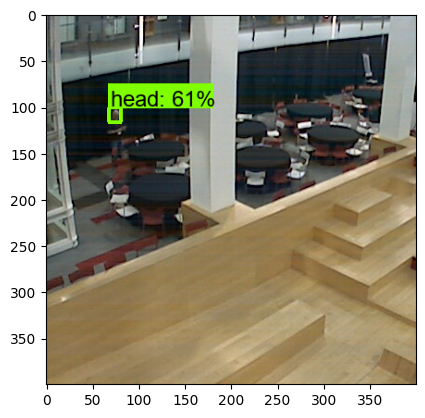

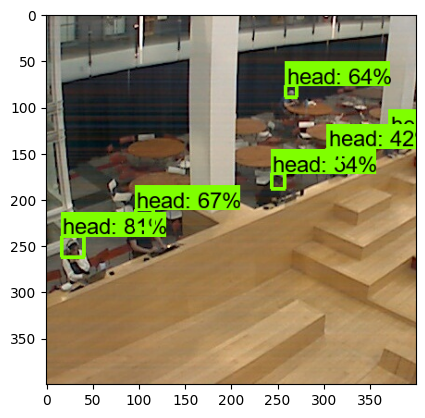

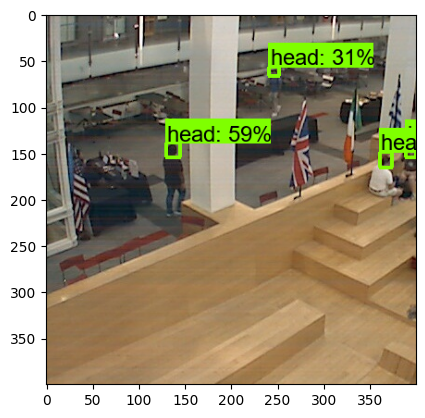

In [6]:
IMAGE_PATHS = [
    "./TensorFlow/workspace/head_detector/images/train/2023_07_18__09_06.jpg",
    "./TensorFlow/workspace/head_detector/images/train/2023_07_18__14_43.jpg",
    "./TensorFlow/workspace/head_detector/images/train/2023_07_19__17_40.jpg",
    ]

for image_path in IMAGE_PATHS:
  detect_heads_in_image(image_path, show_plot=True)
   
plt.show()

## Parse frame data into date and head counts

In [7]:
from datetime import datetime
def parse_frame_filename_to_date(filename):
    return datetime.strptime(filename, "%Y_%m_%d__%H_%M.jpg")

def parse_frame_into_complete_record(filedir, filename):
    filepath = os.path.join(filedir, filename)
    return {
        "date": parse_frame_filename_to_date(filename),
        "num_heads": detect_heads_in_image(filepath, detect_threshold=.5),
        "full_path": filepath
    }

In [8]:
from os import listdir
from os.path import isfile, join
import pandas as pd

images_dir = './frames/'
image_files = [parse_frame_into_complete_record(images_dir, filename) for filename in listdir(images_dir) if isfile(join(images_dir, filename))]
image_df = pd.DataFrame(image_files)
image_df.head()

Running inference for ./frames/2023_07_17__17_34.jpg ... Done: Found 2 heads
Running inference for ./frames/2023_07_17__17_44.jpg ... Done: Found 1 heads
Running inference for ./frames/2023_07_17__17_55.jpg ... Done: Found 1 heads
Running inference for ./frames/2023_07_17__18_05.jpg ... Done: Found 1 heads
Running inference for ./frames/2023_07_17__18_15.jpg ... Done: Found 2 heads
Running inference for ./frames/2023_07_17__18_25.jpg ... Done: Found 2 heads
Running inference for ./frames/2023_07_17__18_36.jpg ... Done: Found 0 heads
Running inference for ./frames/2023_07_17__18_46.jpg ... Done: Found 1 heads
Running inference for ./frames/2023_07_17__18_57.jpg ... Done: Found 1 heads
Running inference for ./frames/2023_07_17__19_07.jpg ... Done: Found 3 heads
Running inference for ./frames/2023_07_17__19_18.jpg ... Done: Found 2 heads
Running inference for ./frames/2023_07_17__19_28.jpg ... Done: Found 3 heads
Running inference for ./frames/2023_07_17__19_38.jpg ... Done: Found 1 heads

,date,num_heads,full_path
0,2023-07-17 17:34:00,2,./frames/2023_07_17__17_34.jpg
1,2023-07-17 17:44:00,1,./frames/2023_07_17__17_44.jpg
2,2023-07-17 17:55:00,1,./frames/2023_07_17__17_55.jpg
3,2023-07-17 18:05:00,1,./frames/2023_07_17__18_05.jpg
4,2023-07-17 18:15:00,2,./frames/2023_07_17__18_15.jpg


## Plots and Interpretation

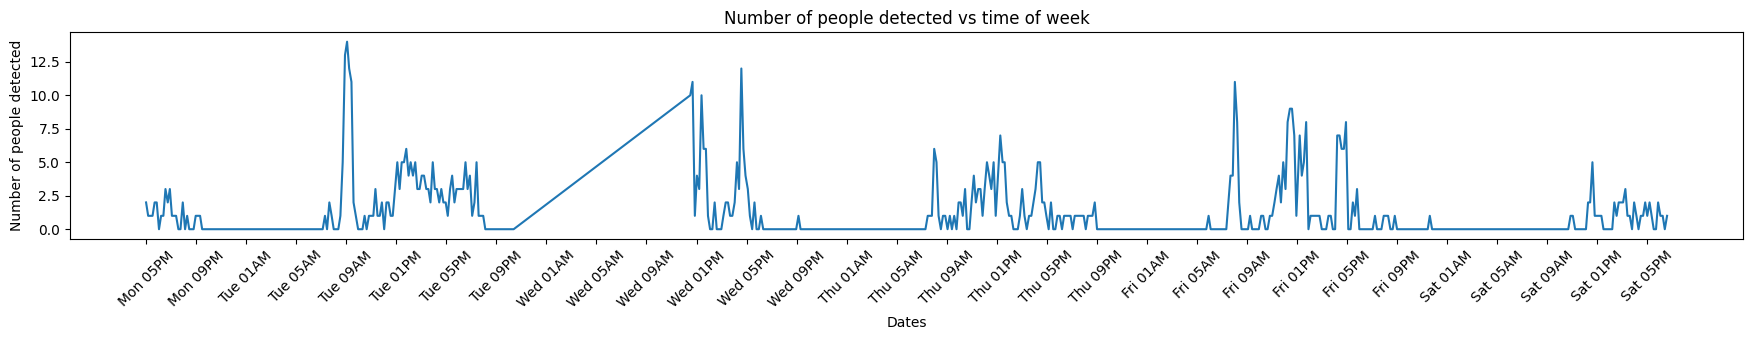

In [9]:

import matplotlib.pyplot as plt
import matplotlib
from datetime import timedelta
  
# plotting a line graph
plt.rcParams["figure.figsize"] = [17.50, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
plt.plot_date(image_df["date"], image_df["num_heads"], linestyle='-', fmt="")
plt.xlabel("Dates")
plt.ylabel("Number of people detected")
plt.title("Number of people detected vs time of week")
plt.xticks(np.arange(min(image_df["date"]), max(image_df["date"]), timedelta(hours=4)), rotation=45)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%a %I%p'))
plt.show()



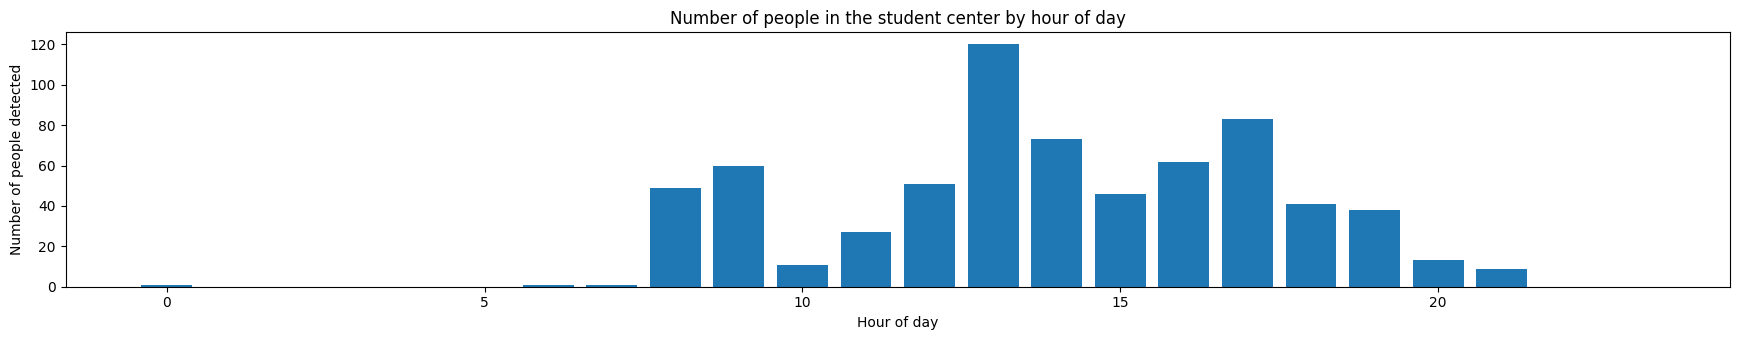

In [10]:
image_df_hourly_grouping = image_df.groupby(image_df.date.map(lambda d: d.hour)).sum()
plt.bar(image_df_hourly_grouping.index, image_df_hourly_grouping.num_heads)
plt.xlabel("Hour of day")
plt.ylabel("Number of people detected")
plt.title("Number of people in the student center by hour of day")
plt.show()